# RNN Time Series for OPEC Predictions

In [24]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
import quandl

In [25]:
quandl.ApiConfig.api_key = "EodKRXnzq6S5xDQy1ZBQ"

Total Data = 3939 days


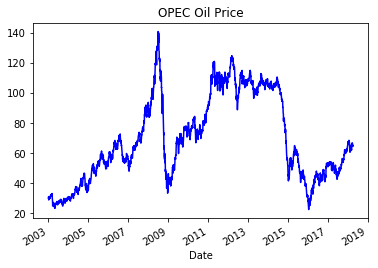

Date
2018-04-06    64.82
2018-04-05    65.18
2018-04-04    64.48
2018-04-03    64.98
2018-04-02    66.09
2018-03-29    65.87
2018-03-28    66.06
2018-03-27    66.81
2018-03-26    66.81
2018-03-23    66.40
Name: Value, dtype: float64

In [26]:
from pandas import Series
def parser(x):
    return pd.to_datetime(x, format='%Y-%m-%d')
series = pd.read_csv('../OPEC.csv',  header=0 , parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print('Total Data = {0} days'.format(len(series)))
series.plot(c='b', title='OPEC Oil Price')
plt.show()
series.head(10)


#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  

In [27]:
TS = np.array(series)
num_periods = 90 #number of periods per vector we are using to predict one period ahead
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print (len(x_batches))
print (len(y_batches))
print (x_batches.shape)
print (y_batches.shape)

43
43
(43, 90, 1)
(43, 90, 1)


#### Pull out our test data

In [28]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 90, 1)
[[[25.14]
  [24.44]
  [23.89]
  [23.92]
  [23.99]
  [23.84]
  [23.85]
  [23.72]
  [23.27]
  [23.64]
  [24.4 ]
  [23.97]
  [25.14]
  [26.24]
  [26.64]
  [26.25]
  [25.71]
  [25.56]
  [25.35]
  [24.96]
  [25.4 ]
  [25.59]
  [25.33]
  [24.91]
  [25.38]
  [26.  ]
  [25.76]
  [26.8 ]
  [27.22]
  [27.23]
  [26.66]
  [25.54]
  [26.84]
  [25.7 ]
  [24.81]
  [26.51]
  [27.12]
  [27.69]
  [29.8 ]
  [30.98]
  [32.42]
  [32.74]
  [32.54]
  [33.11]
  [32.79]
  [32.5 ]
  [32.29]
  [32.12]
  [31.63]
  [32.63]
  [32.48]
  [32.49]
  [32.73]
  [32.44]
  [31.84]
  [31.48]
  [31.95]
  [31.85]
  [31.9 ]
  [32.33]
  [31.91]
  [31.3 ]
  [31.35]
  [31.38]
  [31.25]
  [30.77]
  [30.52]
  [29.98]
  [30.29]
  [30.71]
  [30.58]
  [30.3 ]
  [29.83]
  [30.16]
  [30.56]
  [30.18]
  [30.89]
  [30.9 ]
  [31.21]
  [31.02]
  [30.87]
  [30.66]
  [30.21]
  [29.82]
  [29.82]
  [29.51]
  [28.86]
  [29.72]
  [30.71]
  [30.83]]]


In [47]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

inputs = 1            #number of vectors submitted
hidden = 50          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [48]:
epochs = 10000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    #print(y_pred)

0 	MSE: 24785244.0
100 	MSE: 162479.17
200 	MSE: 135569.19
300 	MSE: 118658.07
400 	MSE: 103834.74
500 	MSE: 88476.8
600 	MSE: 72379.63
700 	MSE: 52391.21
800 	MSE: 22083.32
900 	MSE: 7900.0034
1000 	MSE: 4900.7026
1100 	MSE: 4519.1836
1200 	MSE: 4589.7866
1300 	MSE: 4370.1577
1400 	MSE: 4328.567
1500 	MSE: 4289.648
1600 	MSE: 4261.3545
1700 	MSE: 4248.6084
1800 	MSE: 4211.8296
1900 	MSE: 4187.1313
2000 	MSE: 4165.568
2100 	MSE: 4488.8584
2200 	MSE: 4122.046
2300 	MSE: 4177.765
2400 	MSE: 4081.0474
2500 	MSE: 4073.9563
2600 	MSE: 4041.9753
2700 	MSE: 4024.663
2800 	MSE: 4332.3877
2900 	MSE: 3985.4734
3000 	MSE: 3966.5706
3100 	MSE: 3946.2266
3200 	MSE: 3930.176
3300 	MSE: 3930.7656
3400 	MSE: 3900.541
3500 	MSE: 3888.0808
3600 	MSE: 3874.906
3700 	MSE: 3864.5503
3800 	MSE: 3856.9062
3900 	MSE: 3845.5027
4000 	MSE: 3835.1008
4100 	MSE: 3850.4973
4200 	MSE: 4016.5808
4300 	MSE: 4542.6284
4400 	MSE: 3804.915
4500 	MSE: 3805.1323
4600 	MSE: 3817.47
4700 	MSE: 3836.9724
4800 	MSE: 3782.442


In [46]:
#### Actual vs predictions against test batch 

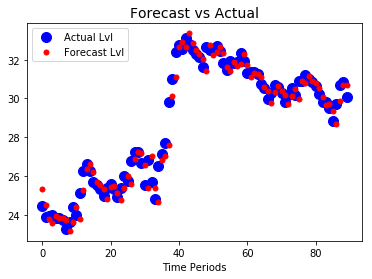

In [23]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual Lvl")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast Lvl")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

